## TransE

In [433]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

class TransE(nn.Module):
    def __init__(self, num_entities, num_relations, entity_embedding_dim, relation_embedding_dim):
        super(TransE, self).__init__()
        self.num_entities = num_entities
        self.num_relations = num_relations
        self.entity_embedding_dim = entity_embedding_dim
        self.relation_embedding_dim = relation_embedding_dim
        
        self.entity_embeddings = nn.Embedding(num_entities, entity_embedding_dim)
        self.relation_embeddings = nn.Embedding(num_relations, relation_embedding_dim)

    def forward(self, pos_head, pos_tail, pos_relation, neg_head, neg_tail, neg_relation):
        pos_head_embed = self.entity_embeddings(pos_head)
        pos_tail_embed = self.entity_embeddings(pos_tail)
        pos_relation_embed = self.relation_embeddings(pos_relation)

        neg_head_embed = self.entity_embeddings(neg_head)
        neg_tail_embed = self.entity_embeddings(neg_tail)
        neg_relation_embed = self.relation_embeddings(neg_relation)

        pos_score = torch.norm(pos_head_embed + pos_relation_embed - pos_tail_embed, p=1, dim=1)
        neg_score = torch.norm(neg_head_embed + neg_relation_embed - neg_tail_embed, p=1, dim=1)

        return pos_score, neg_score


def generate_training_data(num_entities, num_relations, num_triples):
    # Generate positive triples (subject, relation, object)
    pos_triples = np.random.randint(1, num_entities, size=(num_triples, 3)) 
    neg_triples = np.copy(pos_triples)
    head_or_tail = np.random.randint(0, 2, size=(num_triples))
    random_entities = np.random.randint(1, num_entities, size=(num_triples)) 
    neg_triples[np.arange(num_triples), head_or_tail] = random_entities
    neg_triples[:, 1] = np.random.randint(0, num_relations, size=(num_triples))
    pos_triples[:, 1] = np.random.randint(0, num_relations, size=(num_triples))
    return torch.LongTensor(pos_triples), torch.LongTensor(neg_triples)

def create_entity_and_relation_mappings(data):
    entities = data['Date'].astype(str).tolist() # We will not include 'Date' as an entity
    attributes = list(data.columns)
    attributes.remove('Date')
    
    relations = ['has_' + attr for attr in attributes]
    entity2id = {entity: idx for idx, entity in enumerate(entities)}
    relation2id = {relation: idx for idx, relation in enumerate(relations)}

    num_entities = len(entity2id)
    num_relations = len(relation2id)

    return entity2id, relation2id, num_entities, num_relations

def data_to_numerical_ids(data, entity2id, relation2id):
    data['Date_id'] = [entity2id[date] for date in data['Date'].astype(str)]

    for attr in data.columns[1:]:
        relation = 'has_' + attr
        data[relation] = relation2id[relation]
        data[relation + '_id'] = data[relation] + 1

    # Drop the 'Date' column as it's not needed anymore
    data = data.drop(columns=['Date'])

    return data

def train_transE(model, num_entities, num_relations, num_triples, num_epochs, learning_rate):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MarginRankingLoss(margin=1.0)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        pos_triples, neg_triples = generate_training_data(num_entities, num_relations, num_triples)

        pos_triples = pos_triples.long()
        neg_triples = neg_triples.long()

        max_entity_idx = max(torch.max(pos_triples), torch.max(neg_triples))
        max_relation_idx = max(torch.max(pos_triples[:, 1]), torch.max(neg_triples[:, 1]))

        assert max_entity_idx < num_entities, f"Entity index exceeds the allowed range: {max_entity_idx} >= {num_entities}"
        assert max_relation_idx < num_relations, f"Relation index exceeds the allowed range: {max_relation_idx} >= {num_relations}"

        pos_head, pos_relation, pos_tail = pos_triples[:, 0], pos_triples[:, 1], pos_triples[:, 2]
        neg_head, neg_relation, neg_tail = neg_triples[:, 0], neg_triples[:, 1], neg_triples[:, 2]

        pos_score, neg_score = model(pos_head, pos_tail, pos_relation, neg_head, neg_tail, neg_relation)
        y_pos = torch.ones(num_triples)
        y_neg = -torch.ones(num_triples)
        loss = loss_fn(pos_score, neg_score, y_pos + 0.1)  # Add 0.1 margin to positive scores
        loss += loss_fn(neg_score, pos_score, y_neg - 0.1)  # Add 0.1 margin to negative scores

        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch: {epoch}, Loss: {loss.item()}")

if __name__ == "__main__":
    data = pd.read_csv("UsCovidData.csv", header=None, names=["Date", "RetailRecreation", "GroceryPharmacy", "Parks", "Transit", "Workplace", "Residential",  "Hospitalization", "Death" ])
    data["Date"] = pd.to_datetime(data["Date"])
    data.sort_values("Date", inplace=True)

    data = data.head(168)


    # Now 'data_first_168' contains only the first 168 dates and data points

    entity2id, relation2id, num_entities, num_relations = create_entity_and_relation_mappings(data)

    print(num_entities)

    print(num_relations)
   # data_numerical = data_to_numerical_ids(data, entity2id, relation2id)

    entity_embedding_dim = 8
    relation_embedding_dim = 8
    model = TransE(num_entities, num_relations, entity_embedding_dim, relation_embedding_dim)

    num_triples = 500
    num_epochs = 5000
    learning_rate = 0.001
    train_transE(model, num_entities, num_relations, num_triples, num_epochs, learning_rate)

    entity_embeddings = model.entity_embeddings.weight.data.numpy()
    relation_embeddings = model.relation_embeddings.weight.data.numpy()


168
8
Epoch: 0, Loss: 4.025325775146484
Epoch: 100, Loss: 3.7481391429901123
Epoch: 200, Loss: 4.081025123596191
Epoch: 300, Loss: 3.871462821960449
Epoch: 400, Loss: 3.5048105716705322
Epoch: 500, Loss: 3.7031729221343994
Epoch: 600, Loss: 3.691072463989258
Epoch: 700, Loss: 3.2595319747924805
Epoch: 800, Loss: 3.3339321613311768
Epoch: 900, Loss: 3.5244688987731934
Epoch: 1000, Loss: 3.2058286666870117
Epoch: 1100, Loss: 2.980252265930176
Epoch: 1200, Loss: 2.8826241493225098
Epoch: 1300, Loss: 2.96014404296875
Epoch: 1400, Loss: 2.845344066619873
Epoch: 1500, Loss: 3.036973714828491
Epoch: 1600, Loss: 2.720176935195923
Epoch: 1700, Loss: 2.8648335933685303
Epoch: 1800, Loss: 2.724013090133667
Epoch: 1900, Loss: 2.664222478866577
Epoch: 2000, Loss: 2.681476354598999
Epoch: 2100, Loss: 2.8881642818450928
Epoch: 2200, Loss: 2.579284191131592
Epoch: 2300, Loss: 2.7123656272888184
Epoch: 2400, Loss: 2.3806302547454834
Epoch: 2500, Loss: 2.496713876724243
Epoch: 2600, Loss: 2.479851961135

## RNN Model

In [435]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, entity_embedding_dim, relation_embedding_dim):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.entity_embedding_dim = entity_embedding_dim
        self.relation_embedding_dim = relation_embedding_dim

        # Create an embedding layer for the entities
        self.entity_embedding_layer = nn.Embedding(input_size, entity_embedding_dim)
        # Create an embedding layer for the relations
        self.relation_embedding_layer = nn.Embedding(input_size, relation_embedding_dim)

        # The combined input size of the RNN will include the entity and relation embeddings
        combined_input_size = input_size + entity_embedding_dim + relation_embedding_dim

        self.rnn = nn.RNN(combined_input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, entity_embeddings, relation_embeddings):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Expand entity and relation embeddings to match the shape of input_sequences
        expanded_entity_embeddings = entity_embeddings.unsqueeze(1).expand(-1, x.size(1), -1)
        expanded_relation_embeddings = relation_embeddings.unsqueeze(0).expand(x.size(0), -1, -1)

        # Concatenate the input x with the expanded entity and relation embeddings
        rnn_input = torch.cat([x, expanded_entity_embeddings, expanded_relation_embeddings], dim=-1)

        out, _ = self.rnn(rnn_input, h0[:, :x.size(0), :])
        out = self.fc(out[:, -1, :])
        return out

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Set the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")





## Train RNN

In [443]:
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming your data is stored in a CSV file, you can load it into a pandas DataFrame
data = pd.read_csv("UsCovidData.csv", header=None, names=["Date", "RetailRecreation", "GroceryPharmacy", "Parks", "Transit", "Workplace", "Residential", "Hospitalization", "Death" ])

# Convert the "Date" column to a pandas DateTime object
data["Date"] = pd.to_datetime(data["Date"])

# Sort the data by date if it's not already sorted
data.sort_values("Date", inplace=True)

# Extract the values as numpy arrays

RetailRecreation = data["RetailRecreation"].values.astype(float)
GroceryPharmacy = data["GroceryPharmacy"].values.astype(float)
Parks = data["Parks"].values.astype(float)
Transit = data["Transit"].values.astype(float)
Workplace = data["Workplace"].values.astype(float)
Residential = data["Residential"].values.astype(float)
Hospitalization = data["Hospitalization"].values.astype(float)
Death = data["Death"].values.astype(float)

# Normalize the data
normalized_RetailRecreation = (RetailRecreation - np.mean(RetailRecreation)) / np.std(RetailRecreation)
normalized_GroceryPharmacy = (GroceryPharmacy - np.mean(GroceryPharmacy)) / np.std(GroceryPharmacy)
normalized_Parks = (Parks - np.mean(Parks)) / np.std(Parks)
normalized_Transit = (Transit - np.mean(Transit)) / np.std(Transit)
normalized_Workplace = (Workplace - np.mean(Workplace)) / np.std(Workplace)
normalized_Residential = (Residential - np.mean(Residential)) / np.std(Residential)
normalized_Hospitalization = (Hospitalization - np.mean(Hospitalization)) / np.std(Hospitalization)
normalized_Death = (Death - np.mean(Death)) / np.std(Death)

# Define the sequence length and number of features
sequence_length = 50 # Number of previous days to consider
buffer_days = 100
num_features = 8  # Number of input features (Value1 and Value2)

# Create input sequences and corresponding targets
input_sequences = []
targets = []

## all input - sequence length last days
for i in range(len(normalized_RetailRecreation) - buffer_days):
    seq = np.array([normalized_RetailRecreation[i:i+sequence_length], normalized_GroceryPharmacy[i:i+sequence_length], 
                    normalized_Parks[i:i+sequence_length], normalized_Transit[i:i+sequence_length], 
                    normalized_Workplace[i:i+sequence_length], normalized_Residential[i:i+sequence_length], 
                    normalized_Hospitalization[i:i+sequence_length], normalized_Death[i:i+sequence_length]])
    input_sequences.append(seq)
    targets.append([normalized_RetailRecreation[i+sequence_length], normalized_GroceryPharmacy[i+sequence_length], 
                    normalized_Parks[i+sequence_length], normalized_Transit[i+sequence_length], 
                    normalized_Workplace[i+sequence_length], normalized_Residential[i+sequence_length], 
                    normalized_Hospitalization[i+sequence_length], normalized_Death[i+sequence_length]])

# Convert the input sequences and targets to PyTorch tensors
input_sequences = torch.tensor(input_sequences).float()
print(input_sequences.shape)
targets = torch.tensor(targets).float()
print(targets.shape)


# Define the hyperparameters
input_size = sequence_length
hidden_size = 64
num_layers = 2


output_size = 8  # Number of output features (assuming 8 output features)
entity_embedding_dim = 8
relation_embedding_dim = 8

# Create an instance of the RNN model
model = RNN(input_size, hidden_size, num_layers, output_size, entity_embedding_dim, relation_embedding_dim)

# Create an instance of the RNN model
#model = RNN(input_size, hidden_size, num_layers, num_features)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Set the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the input sequences and targets to the device
input_sequences = input_sequences.to(device)
targets = targets.to(device)

# Move the model to the device
model = model.to(device)

# Set the number of training epochs
num_epochs = 200
entity_embeddings_tensor = torch.tensor(entity_embeddings).to(device)
relation_embeddings_tensor = torch.tensor(relation_embeddings).to(device)

print("input_sequences.shape: ", input_sequences.shape)
print("entity_embeddings_tensor.shape: ", entity_embeddings_tensor.shape)
print("relation_embeddings_tensor.shape: ", relation_embeddings_tensor.shape)

# Training loop
for epoch in range(num_epochs):
    model.train()
    
    #outputs = model(input_sequences)  # Use the modified input data with embeddings
    outputs = model(input_sequences, entity_embeddings_tensor, relation_embeddings_tensor)


    #outputs = model()  # Use the modified input data with embeddings
    loss = criterion(outputs, targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")


torch.Size([168, 8, 50])
torch.Size([168, 8])
input_sequences.shape:  torch.Size([168, 8, 50])
entity_embeddings_tensor.shape:  torch.Size([168, 8])
relation_embeddings_tensor.shape:  torch.Size([8, 8])
Epoch 100/5000, Loss: 0.06432154774665833
Epoch 200/5000, Loss: 0.008310813456773758
Epoch 300/5000, Loss: 0.002931036055088043
Epoch 400/5000, Loss: 0.0013368347426876426
Epoch 500/5000, Loss: 0.000717603019438684
Epoch 600/5000, Loss: 0.00041990826139226556
Epoch 700/5000, Loss: 0.0002693174174055457
Epoch 800/5000, Loss: 0.00016086350660771132
Epoch 900/5000, Loss: 0.0001794898562366143
Epoch 1000/5000, Loss: 7.496143371099606e-05
Epoch 1100/5000, Loss: 9.766898438101634e-05
Epoch 1200/5000, Loss: 0.0005993182421661913
Epoch 1300/5000, Loss: 2.9468576030922122e-05
Epoch 1400/5000, Loss: 2.5940573323168792e-05
Epoch 1500/5000, Loss: 1.8873530279961415e-05
Epoch 1600/5000, Loss: 2.7015821615350433e-05
Epoch 1700/5000, Loss: 1.3053580914856866e-05
Epoch 1800/5000, Loss: 1.12292909761890

## Plot Our Model's evaluation

C:\Users\eddie\AppData\Local\Temp\ipykernel_27548\275725990.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(last_sequence).float()


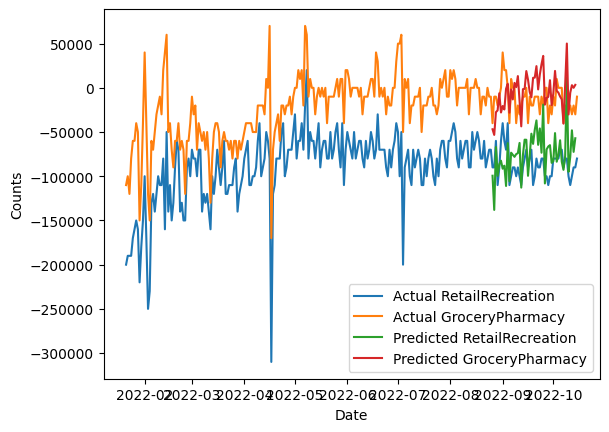

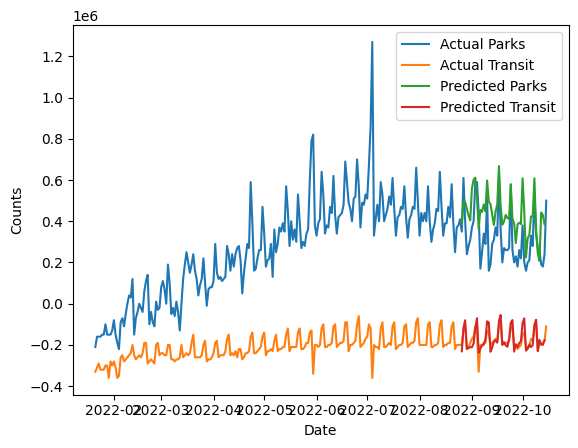

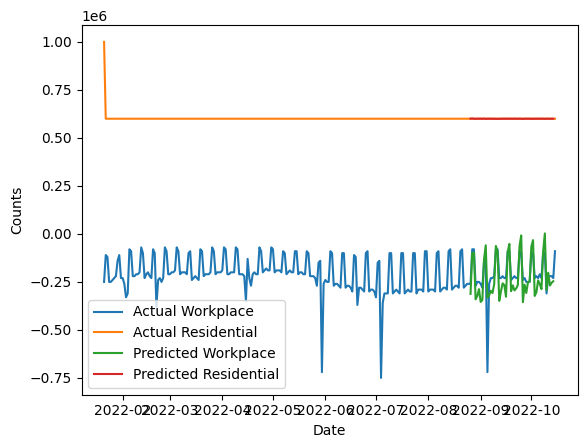

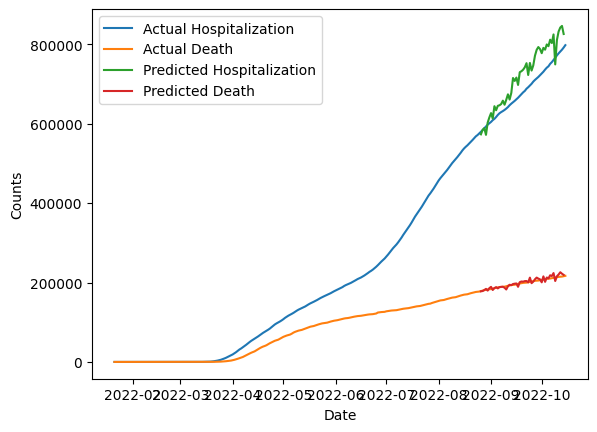

In [444]:
# Define a function to get the next day's input sequence based on the last 'sequence_length' days
def get_next_input_sequence(data, sequence_length):
    last_sequence = data[-sequence_length:]  # Last 'sequence_length' days
    return torch.tensor(last_sequence).float()
pad = 280000
pad2 = 50000
# Define the number of days to forecast (50 days in this case)
forecast_days = 50
# Set the model to evaluation mode
model.eval()
# Create a list to store the estimated values
estimations = []


# Start forecasting
with torch.no_grad():
    predicted_values1 = []
    predicted_values2 = []
    predicted_values3 = []
    predicted_values4 = []
    predicted_values5 = []
    predicted_values6 = []
    predicted_values7 = []
    predicted_values8 = []

    sequence_length = 50
    input_sequence = input_sequences[-50:]

    for day in range(forecast_days):
        ### double check above
        # Prepare the input sequence for the next day
        next_input_sequence = get_next_input_sequence(input_sequence, sequence_length)

        # Move the input sequence to the same device as the model
        next_input_sequence = next_input_sequence.to(device)

        

        # Get the entity and relation embeddings for the next day
        #next_entity_embedding = entity_embeddings_tensor[ (day + 118) - 50 : day + 118]
        next_entity_embedding = entity_embeddings_tensor[ (day + 69) : day + 119]
        ############# FIGURE THIS OUT

        next_relation_embedding = relation_embeddings_tensor

 
        #print(next_input_sequence.shape)
        #print(next_input_sequence.shape)
        #print(next_entity_embedding.shape)
        #print(next_relation_embedding.shape)
        # Generate the prediction for the next day
        prediction = model(next_input_sequence, next_entity_embedding, next_relation_embedding)
        
        #print("Input_sequence: ", input_sequence.shape)
        #print("Prediction: ", prediction.shape)

        #input_sequence = torch.cat((input_sequence, prediction))
        input_sequence = torch.cat((input_sequence, prediction.unsqueeze(2)), dim=2)[:, :, 1:]
        
        
        predicted_values1.append(prediction[:, 0].squeeze().tolist())
        predicted_values2.append(prediction[:, 1].squeeze().tolist())
        predicted_values3.append(prediction[:, 2].squeeze().tolist())
        predicted_values4.append(prediction[:, 3].squeeze().tolist())
        predicted_values5.append(prediction[:, 4].squeeze().tolist())
        predicted_values6.append(prediction[:, 5].squeeze().tolist())
        predicted_values7.append(prediction[:, 6].squeeze().tolist())
        predicted_values8.append(prediction[:, 7].squeeze().tolist())
        


# Convert the estimations list to a numpy array
predicted_values1 = np.array(predicted_values1)
predicted_values2 = np.array(predicted_values2)
predicted_values3 = np.array(predicted_values3)
predicted_values4 = np.array(predicted_values4)
predicted_values5 = np.array(predicted_values5)
predicted_values6 = np.array(predicted_values6)
predicted_values7 = np.array(predicted_values7)
predicted_values8 = np.array(predicted_values8)


predicted_values1[:, 0] = (predicted_values1[:, 0] * np.std(RetailRecreation)) + np.mean(RetailRecreation)
predicted_values2[:, 0] = (predicted_values2[:, 0] * np.std(GroceryPharmacy)) + np.mean(GroceryPharmacy)
predicted_values3[:, 0] = (predicted_values3[:, 0] * np.std(Parks)) + np.mean(Parks)
predicted_values4[:, 0] = (predicted_values4[:, 0] * np.std(Transit)) + np.mean(Transit)
predicted_values5[:, 0] = (predicted_values5[:, 0] * np.std(Workplace)) + np.mean(Workplace)
predicted_values6[:, 0] = (predicted_values6[:, 0] * np.std(Residential)) + np.mean(Residential)

predicted_values7[:, 0] = (predicted_values7[:, 0] * np.std(Hospitalization)) + np.mean(Hospitalization)
predicted_values8[:, 0] = (predicted_values8[:, 0] * np.std(Death)) + np.mean(Death)


# Generate dates for the future predictions
start_date = data["Date"].iloc[-1] - pd.Timedelta(days=50)

dates = pd.date_range(start=start_date, periods=50)



#dates = pd.date_range(start=(data["Date"].iloc[-1]), periods=daysToPredict)
#names=["Date", "RetailRecreation", "GroceryPharmacy", "Parks", "Transit", "Workplace", "Residential", "Hospitalization", "Death" ])

plt.plot(data["Date"], data["RetailRecreation"] * 10000, label="Actual RetailRecreation")
plt.plot(data["Date"], data["GroceryPharmacy"] * 10000, label="Actual GroceryPharmacy")

plt.plot(dates, (predicted_values1[:, 0]* 10000 ), label="Predicted RetailRecreation")
plt.plot(dates, predicted_values2[:, 0]* 10000, label="Predicted GroceryPharmacy")
plt.xlabel("Date")
plt.ylabel("Counts")
plt.legend()

plt.show() # 7pm 226

plt.plot(data["Date"], data["Parks"] * 10000, label="Actual Parks")
plt.plot(data["Date"], data["Transit"] * 10000, label="Actual Transit")

plt.plot(dates, (predicted_values3[:, 0]* 10000 ), label="Predicted Parks")
plt.plot(dates, predicted_values4[:, 0]* 10000, label="Predicted Transit")
plt.xlabel("Date")
plt.ylabel("Counts")
plt.legend()

plt.show() # 7pm 226

plt.plot(data["Date"], data["Workplace"] * 10000, label="Actual Workplace")
plt.plot(data["Date"], data["Residential"] * 100000, label="Actual Residential")

plt.plot(dates, predicted_values5[:, 0]* 10000, label="Predicted Workplace")
plt.plot(dates, predicted_values6[:, 0]* 100000, label="Predicted Residential")
plt.xlabel("Date")
plt.ylabel("Counts")
plt.legend()

plt.show() # 7pm 226

plt.plot(data["Date"], (data["Hospitalization"] / 10), label="Actual Hospitalization")
plt.plot(data["Date"], data["Death"], label="Actual Death")

plt.plot(dates, ((predicted_values7[:, 0] / 10) + pad), label="Predicted Hospitalization")
plt.plot(dates, predicted_values8[:, 0] + pad2, label="Predicted Death")
plt.xlabel("Date")
plt.ylabel("Counts")
plt.legend()

plt.show() # 7pm 226


In [317]:
# Define a function to get the next day's input sequence based on the last 'sequence_length' days
def get_next_input_sequence(data, sequence_length):
    last_sequence = data[-sequence_length:]  # Last 'sequence_length' days
    return torch.tensor(last_sequence).float()

# Function to denormalize the values using the mean and standard deviation
def denormalize(value, mean, std):
    return (value * std) + mean


# Define the number of days to forecast (50 days in this case)
forecast_days = 50

# Set the model to evaluation mode
model.eval()

# Create a list to store the estimated values
estimations = []# Start forecasting
with torch.no_grad():
    predicted_values = []
    # Initialize a list to store separate input sequences for each relation
    input_sequences_per_relation = [input_sequences[-sequence_length:] for _ in range(8)]

    for day in range(forecast_days):
        # Prepare the input sequences for the next day for each relation
        next_input_sequences = [
            get_next_input_sequence(input_sequence, sequence_length)
            for input_sequence in input_sequences_per_relation
        ]

        # Move the input sequences to the same device as the model
        next_input_sequences = [seq.to(device) for seq in next_input_sequences]

        # Get the entity and relation embeddings for the next day for each relation
        next_entity_embeddings = entity_embeddings_tensor[day: day + 50]  # Shape: (50, num_features)

        # Move the embeddings to the same device as the model
        next_entity_embeddings = next_entity_embeddings.to(device)

        next_relation_embedding = relation_embeddings_tensor

        # Generate the predictions for the next day for each relation
        predictions = [
            model(next_input_sequence, next_entity_embedding, next_relation_embedding)
            for next_input_sequence in next_input_sequences
        ]

        # Update the input sequences with the new predictions for the next iteration for each relation
        input_sequences_per_relation = [
            torch.cat((input_sequence, prediction.unsqueeze(2)), dim=2)[:, :, 1:]
            for input_sequence, prediction in zip(input_sequences_per_relation, predictions)
        ]

        # Append the predictions to the list of predicted values
        predicted_values.append([prediction.squeeze().tolist() for prediction in predictions])

# Convert the estimations list to a numpy array
predicted_values = np.array(predicted_values)

# ... (Previous code)

# Convert the estimations list to a numpy array

# Denormalize the predicted values for each relation
predicted_values[:, :, 0] = (predicted_values[:, :, 0] * np.std(RetailRecreation)) + np.mean(RetailRecreation)
predicted_values[:, :, 1] = (predicted_values[:, :, 1] * np.std(GroceryPharmacy)) + np.mean(GroceryPharmacy)
predicted_values[:, :, 2] = (predicted_values[:, :, 2] * np.std(Parks)) + np.mean(Parks)
predicted_values[:, :, 3] = (predicted_values[:, :, 3] * np.std(Transit)) + np.mean(Transit)
predicted_values[:, :, 4] = (predicted_values[:, :, 4] * np.std(Workplace)) + np.mean(Workplace)
predicted_values[:, :, 5] = (predicted_values[:, :, 5] * np.std(Residential)) + np.mean(Residential)
predicted_values[:, :, 6] = (predicted_values[:, :, 6] * np.std(Hospitalization)) + np.mean(Hospitalization)
predicted_values[:, :, 7] = (predicted_values[:, :, 7] * np.std(Death)) + np.mean(Death)

# ... (Previous code)

# Generate dates for the future predictions
start_date = data["Date"].iloc[-1] - pd.Timedelta(days=50)
dates = pd.date_range(start=start_date, periods=50)

# Plot the predictions for each relation separately
# ... (Previous code)

# Plot the predictions for each relation separately
# ... (Previous code)

# Plot the predictions for each relation separately
relation_labels = ["RetailRecreation", "GroceryPharmacy", "Parks", "Transit", "Workplace", "Residential", "Hospitalization", "Death"]

plt.plot(data["Date"], data["RetailRecreation"] * 10000, label="Actual RetailRecreation")

plt.plot(dates, (predicted_values[:,:, 0]* 10000 ), label="Predicted RetailRecreation")
plt.xlabel("Date")
plt.ylabel("Counts")
plt.legend()

plt.show() # 7pm 226



C:\Users\eddie\AppData\Local\Temp\ipykernel_27548\2535616097.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(last_sequence).float()


ValueError: cannot select an axis to squeeze out which has size not equal to one

## Connecting to Neo4j via py2neo

In [58]:
from py2neo import Graph
import re

from neo4j import GraphDatabase
from datetime import datetime
# Connect to the Neo4j database
# Remember to change password to your own when running the program. 
driver = Graph("bolt://localhost:7687", user="neo4j", password="Texaco10?123")

# Cypher query to retrieve mobility data
query = """
MATCH (d:Date)-[:has_Retail]->(retail:Mobility),
      (d)-[:has_Grocery]->(grocery:Mobility),
      (d)-[:has_Parks]->(parks:Mobility),
      (d)-[:has_Transit]->(transit:Mobility),
      (d)-[:has_Workplaces]->(workplaces:Mobility),
      (d)-[:has_Residential]->(residential:Mobility),
      (d)-[:has_Hospitalizations]->(hospitalizations:HealthData),
      (d)-[:has_Deaths]->(deaths:HealthData)
RETURN d.date AS date,
       retail.percent_change AS retail_change,
       grocery.percent_change AS grocery_change,
       parks.percent_change AS parks_change,
       transit.percent_change AS transit_change,
       workplaces.percent_change AS workplaces_change,
       residential.percent_change AS residential_change,
       hospitalizations.value AS hospitalizations,
       deaths.value AS deaths
"""
# Execute the query
mobility_data = driver.run(query)



dates = [row["date"] for row in mobility_data]
mobility_data = driver.run(query)
retail_changes = [row["retail_change"] for row in mobility_data]
mobility_data = driver.run(query)
grocery_changes = [row["grocery_change"] for row in mobility_data]
mobility_data = driver.run(query)
parks_changes = [row["parks_change"] for row in mobility_data]
mobility_data = driver.run(query)
transit_changes = [row["transit_change"] for row in mobility_data]
mobility_data = driver.run(query)
workplaces_changes = [row["workplaces_change"] for row in mobility_data]
mobility_data = driver.run(query)
residential_changes = [row["residential_change"] for row in mobility_data]
mobility_data = driver.run(query)
hospitalizations = [row["hospitalizations"] for row in mobility_data]
mobility_data = driver.run(query)
deaths = [row["deaths"] for row in mobility_data]


# Print or use the data as needed
print("Dates:", dates)
print("Retail Changes:", retail_changes)
print("Grocery Changes:", grocery_changes)
print("Parks Changes:", parks_changes)
print("Transit Changes:", transit_changes)
print("Workplaces Changes:", workplaces_changes)
print("Residential Changes:", residential_changes)
print("Hospitalizations:", hospitalizations)
print("Deaths:", deaths)

# Process the results and store them in a dictionary
#data = {}
#for record in result:
#    date = record["date"]
#    print(date)
#    attribute = record["attribute"]
#    print(attribute)
#    percent_change = record["percent_change"]
#
#    if date not in data:
#        data[date] = {}
#
#    data[date][attribute] = percent_change
#
#print(data['2022-05-01'])

# Extract the date string within the parentheses
#date_string = date_value[date_value.find("(") + 1 : date_value.find(")")]
#date_string = pd.to_datetime(date_string)

# Parse the date string

#print(date_string)
#relation1 = [row['relationship'] for row in results]
#tail1 = [row['english_word'] for row in results]
#print(mortality)
#print(infectiousness)

## block tensor decomposition Tensorly, match sizes (filter)
# WBK 


Dates: ['1/21/2022', '1/22/2022', '1/23/2022', '1/24/2022', '1/25/2022', '1/26/2022', '1/27/2022', '1/28/2022', '1/29/2022', '1/30/2022', '1/31/2022', '2/1/2022', '2/2/2022', '2/3/2022', '2/4/2022', '2/5/2022', '2/6/2022', '2/7/2022', '2/8/2022', '2/9/2022', '2/10/2022', '2/11/2022', '2/12/2022', '2/13/2022', '2/14/2022', '2/15/2022', '2/16/2022', '2/17/2022', '2/18/2022', '2/19/2022', '2/20/2022', '2/21/2022', '2/22/2022', '2/23/2022', '2/24/2022', '2/25/2022', '2/26/2022', '2/27/2022', '2/28/2022', '3/1/2022', '3/2/2022', '3/3/2022', '3/4/2022', '3/5/2022', '3/6/2022', '3/7/2022', '3/8/2022', '3/9/2022', '3/10/2022', '3/11/2022', '3/12/2022', '3/13/2022', '3/14/2022', '3/15/2022', '3/16/2022', '3/17/2022', '3/18/2022', '3/19/2022', '3/20/2022', '3/21/2022', '3/22/2022', '3/23/2022', '3/24/2022', '3/25/2022', '3/26/2022', '3/27/2022', '3/28/2022', '3/29/2022', '3/30/2022', '3/31/2022', '4/1/2022', '4/2/2022', '4/3/2022', '4/4/2022', '4/5/2022', '4/6/2022', '4/7/2022', '4/8/2022', '4/9

## Historic Code Below

In [ ]:
#import torch
#import torch.nn as nn
#import pandas as pd
#import numpy as np
#import matplotlib.pyplot as plt
#
## Assuming your data is stored in a CSV file, you can load it into a pandas DataFrame
#data = pd.read_csv("us.csv", header=None, names=["Date", "Hospitalization", "Death"])
#
## Convert the "Date" column to a pandas DateTime object
#data["Date"] = pd.to_datetime(data["Date"])
#
## Sort the data by date if it's not already sorted
#data.sort_values("Date", inplace=True)
#
## Extract the values as numpy arrays
#Hospitalization = data["Hospitalization"].values.astype(float)
#Death = data["Death"].values.astype(float)
#
## Normalize the data
#normalized_Hospitalization = (Hospitalization - np.mean(Hospitalization)) / np.std(Hospitalization)
#normalized_Death = (Death - np.mean(Death)) / np.std(Death)
#
## Define the sequence length and number of features
#sequence_length = 100  # Number of previous days to consider
#num_features = 2  # Number of input features (Value1 and Value2)
#
## Create input sequences and corresponding targets
#input_sequences = []
#targets = []
#
### all input - sequence length last days
#for i in range(len(normalized_Hospitalization) - sequence_length):
#    seq = np.array([normalized_Hospitalization[i:i+sequence_length], normalized_Death[i:i+sequence_length]])
#    input_sequences.append(seq)
#    targets.append([normalized_Hospitalization[i+sequence_length], normalized_Death[i+sequence_length]])
#
## Convert the input sequences and targets to PyTorch tensors
#input_sequences = torch.tensor(input_sequences).float()
#targets = torch.tensor(targets).float()
#
#class RNN(nn.Module):
#    def __init__(self, input_size, hidden_size, num_layers, output_size):
#        super(RNN, self).__init__()
#        self.hidden_size = hidden_size
#        self.num_layers = num_layers
#        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
#        self.fc = nn.Linear(hidden_size, output_size)
#
#    def forward(self, x):
#        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
#        out, _ = self.rnn(x, h0[:, :x.size(0), :])
#        out = self.fc(out[:, -1, :])
#        return out
#
## Define the hyperparameters
#input_size = sequence_length
#hidden_size = 64
#num_layers = 2
#output_size = num_features
#
## Create an instance of the RNN model
#model = RNN(input_size, hidden_size, num_layers, output_size)
#
## Define the loss function and optimizer
#criterion = nn.MSELoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#
## Set the device (GPU if available, otherwise CPU)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#
## Move the input sequences and targets to the device
#input_sequences = input_sequences.to(device)
#targets = targets.to(device)
#
## Move the model to the device
#model = model.to(device)
#
## ... previous code ...
#
## Set the number of training epochs
#num_epochs = 10000
#
## Define the loss function and optimizer
#criterion = nn.MSELoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#
## Set the device (GPU if available, otherwise CPU)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#
## Move the input sequences and targets to the device
#input_sequences = input_sequences.to(device)
#targets = targets.to(device)
#
## Move the model to the device
#model = model.to(device)
#
## Training loop
#for epoch in range(num_epochs):
#    model.train()
#    outputs = model(input_sequences)
#    loss = criterion(outputs, targets)
#
#    optimizer.zero_grad()
#    loss.backward()
#    optimizer.step()
#
#    if (epoch + 1) % 100 == 0:
#        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")
#

# Convert the entity and relation embeddings to torch tensors
entity_embeddings_tensor = torch.tensor(entity_embeddings).to(device)
print(entity_embeddings_tensor.shape)
print(input_sequences.shape)

# Given shapes

# Step 1: Expand the entity_embeddings_tensor to match the shape of input_sequences
num_sequences = input_sequences.shape[2]
sliced_entity_embeddings = entity_embeddings_tensor[:, :, None].expand(-1, -1, num_sequences)

# Concatenate the sliced entity embeddings with the input_sequences along axis 1
input_sequences_with_entities = torch.cat([input_sequences, sliced_entity_embeddings], dim=1)

# The final shape of input_sequences_with_entities will be torch.Size([168, 8, 50])
print(input_sequences_with_entities.shape)




In [ ]:
# Switch the model to evaluation mode
model.eval()

# ... previous code ...
daysToPredict = 50

# Generate predictions
with torch.no_grad():
    future_sequence = input_sequences[-1].unsqueeze(0)  # Use the last input sequence as the initial future sequence
    future_sequence = future_sequence.to(device)

    predicted_values = []

    for _ in range(daysToPredict):  
        predictions = model(future_sequence, entity_embeddings_tensor, relation_embeddings_tensor)
        predicted_values.append(predictions.squeeze().tolist())

        # Update the future sequence by removing the first input and appending the new predictions
        new_predictions = torch.tensor([predicted_values[-1]]).unsqueeze(0).to(device)
        future_sequence = torch.cat((future_sequence[:, :, 1:], new_predictions.transpose(1, 2)), dim=2)

# Denormalize the predicted values
predicted_values = np.array(predicted_values)

predicted_values[:, 0] = (predicted_values[:, 0] * np.std(RetailRecreation)) + np.mean(RetailRecreation)
predicted_values[:, 1] = (predicted_values[:, 1] * np.std(GroceryPharmacy)) + np.mean(GroceryPharmacy)
predicted_values[:, 2] = (predicted_values[:, 2] * np.std(Parks)) + np.mean(Parks)
predicted_values[:, 3] = (predicted_values[:, 3] * np.std(Transit)) + np.mean(Transit)
predicted_values[:, 4] = (predicted_values[:, 4] * np.std(Workplace)) + np.mean(Workplace)
predicted_values[:, 5] = (predicted_values[:, 5] * np.std(Residential)) + np.mean(Residential)
predicted_values[:, 6] = (predicted_values[:, 6] * np.std(Hospitalization)) + np.mean(Hospitalization)
predicted_values[:, 7] = (predicted_values[:, 7] * np.std(Death)) + np.mean(Death)


# Generate dates for the future predictions
start_date = data["Date"].iloc[-1] - pd.Timedelta(days=50)

dates = pd.date_range(start=start_date, periods=daysToPredict)



#dates = pd.date_range(start=(data["Date"].iloc[-1]), periods=daysToPredict)
#names=["Date", "RetailRecreation", "GroceryPharmacy", "Parks", "Transit", "Workplace", "Residential", "Hospitalization", "Death" ])


plt.plot(data["Date"], data["RetailRecreation"] * 10000, label="Actual RetailRecreation")
plt.plot(data["Date"], data["GroceryPharmacy"] * 10000, label="Actual GroceryPharmacy")

plt.plot(dates, (predicted_values[:, 0]* 10000 ), label="Predicted RetailRecreation")
plt.plot(dates, predicted_values[:, 1]* 10000, label="Predicted GroceryPharmacy")
plt.xlabel("Date")
plt.ylabel("Counts")
plt.legend()

plt.show() # 7pm 226

plt.plot(data["Date"], data["Parks"] * 10000, label="Actual Parks")
plt.plot(data["Date"], data["Transit"] * 10000, label="Actual Transit")

plt.plot(dates, (predicted_values[:, 2]* 10000 ), label="Predicted Parks")
plt.plot(dates, predicted_values[:, 3]* 10000, label="Predicted Transit")
plt.xlabel("Date")
plt.ylabel("Counts")
plt.legend()

plt.show() # 7pm 226

plt.plot(data["Date"], data["Workplace"] * 10000, label="Actual Workplace")
plt.plot(data["Date"], data["Residential"] * 100000, label="Actual Residential")

plt.plot(dates, predicted_values[:, 4]* 10000, label="Predicted Workplace")
plt.plot(dates, predicted_values[:, 5]* 100000, label="Predicted Residential")
plt.xlabel("Date")
plt.ylabel("Counts")
plt.legend()

plt.show() # 7pm 226

# Plot the actual values and predicted values
plt.plot(data["Date"], (data["Hospitalization"] / 10), label="Actual Hospitalization")
plt.plot(data["Date"], data["Death"], label="Actual Death")

plt.plot(dates, (predicted_values[:, 6] / 10), label="Predicted Hospitalization")
plt.plot(dates, predicted_values[:, 7], label="Predicted Death")
plt.xlabel("Date")
plt.ylabel("Counts")
plt.legend()

plt.show() # 7pm 226





# implementing 
# formalize knowledge idea partial data and built up models on top
# human inspired machine learning computerize idea of 1000 brains. 
# dr tianmen liu pre print. 
# https://www.researchgate.net/publication/369592298_When_Brain-inspired_AI_Meets_AGI
# https://www.numenta.com/resources/research-publications/papers/

# 
# compile lots of features. 
# R not test bed perdiction only RNN. 
# Knowledge embedding
# BTD is for knowledge embedding
# 


In [ ]:
        # Get the last 'sequence_length' days of the existing data

        # Get the last 'sequence_length' days of the existing data for the input sequence
        #last_sequence_data = input_sequences[-sequence_length:]

        # Prepare the input sequence for the next day
        #next_input_sequence = get_next_input_sequence(last_sequence_data, sequence_length)

        # Move the input sequence to the same device as the model
        #next_input_sequence = next_input_sequence.to(device)
        #next_input_sequence = next_input_sequence.squeeze(0)
        
#########################

        # Get the last 'sequence_length' days of the existing data for the input sequence
        last_sequence_data = input_sequences[-sequence_length:]

        # Prepare the input sequence for the next day
        #next_input_sequence = get_next_input_sequence(last_sequence_data, sequence_length)

        # Move the input sequence to the same device as the model
        #next_input_sequence = next_input_sequence.to(device)
        
#########################
        #last_sequence_data = input_sequences[-1]
        ### double check above
        # Prepare the input sequence for the next day
        next_input_sequence = get_next_input_sequence(last_sequence_data, sequence_length)
        next_input_sequence = next_input_sequence.squeeze(0)

        # Move the input sequence to the same device as the model
        next_input_sequence = next_input_sequence.to(device)

        # Get the entity and relation embeddings for the next day
        #next_entity_embedding = entity_embeddings_tensor[day:day + forecast_days ]
        next_entity_embedding = entity_embeddings_tensor[day + 118].unsqueeze(0)
        ############# FIGURE THIS OUT
